# Convolutional Neural Networks

The fully connected neural network we looked at in the previous lesson takes in a vector as input thus a flattened image could be passed in as input and used for classification problems successfully. But this is not the best way to do it. When trying to interpret an image, the spatial relations between the different pixels is crucial to our understanding. When we flatten the image, we lose this information.

Convolutional neural networks solve this very problem. Rather than performing a matrix multiplication, a convolution operation is performed which can take in a 2d input and give a 2d output hence keep the information about the spatial relations of the pixels. This greatly increases their performance on image and video processing tasks.

In the convolution proccess, you have a filter which you start on the top left side of the image and slide across the whole image, taking a dot product between the values of the filter and pixel values of the image. Bear in mind that colour images have three colour channels so your filter may be 3d so you take the dot product across a 3d volume. Each dot product corresponds to a single activation value in a 2d matrix of neurons which corresponds to a single layer in the output.

![image](images/CNN_RGB.JPG)

The animation below shows how a 1x3x3 filter is applied to a 1x5x5 image. Notice how the output has high  values when the filter is passed over locations where there is an X shape in the input image. This is because the values of the filter are such that it is performing pattern matching for the X shape.

![image](images/convolution_animation.gif)

Convolution operations have 3 parameters, the kernel size, which is the width and height of our filter, the stride, which is the number of pixels we translate our kernel by to compute the next feature, and the padding which is how many layers of 0 padding we add to the input image. We som

![image](images/CNN_diagram.JPG)

Each computed feature is a linear function of the pixels in a local region as opposed to fully connected nets where each computed feature is a linear function of all the pixels in the image.

We have some prior understanding of how image data should be processed. We apply the same set of weights at different locations all over the image because we know that features are repeated at different locations throughout the image. This makes the learned features translation invariant.


![image](images/CNN_FNN_comparison.JPG)


For a long time, operations like this were used in computer vision to find different patterns in images with the engineers having to manually tune the values of the filters to perform the required function. The only difference now is that we apply an activation such as Relu or Sigmoid at each layer and after setting up the structure of the network, we initialize the filter values randomly before using gradient descent to automatically tune the values of the filters. We can also apply max pooling operations to subsample the output at each layer therefore reducing the number of parameters that need to be learned for the succeeding convolution operation.


Just like before, each layer in the whole network learns higher level abstract features from the inputs.

In [107]:
import torch
from torchvision import datasets, transforms

# GET THE TRAINING DATASET
train_data = datasets.MNIST(root='MNIST-data',                        # where is the data (going to be) stored
                            transform=transforms.ToTensor(),          # transform the data from a PIL image to a tensor
                            train=True,                               # is this training data?
                            download=True                             # should i download it if it's not already here?
                           )

# GET THE TEST DATASET
test_data = datasets.MNIST(root='MNIST-data',
                           transform=transforms.ToTensor(),
                           train=False,
                          )

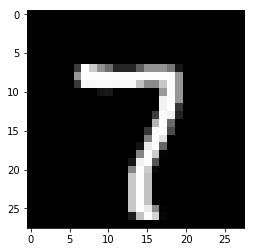

In [108]:
import matplotlib.pyplot as plt
import numpy as np
x = train_data[np.random.randint(0, 300)][0]    # get a random example
#print(x)
plt.imshow(x[0].numpy(),cmap='gray')
plt.show()

In [109]:
# FURTHER SPLIT THE TRAINING INTO TRAINING AND VALIDATION
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])    # split into 50K training & 10K validation

In [110]:
batch_size = 128

# MAKE TRAINING DATALOADER
train_loader = torch.utils.data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE VALIDATION DATALOADER
val_loader = torch.utils.data.DataLoader(
    val_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE TEST DATALOADER
test_loader = torch.utils.data.DataLoader(
    test_data,
    shuffle=True,
    batch_size=batch_size
)

In [111]:
import torch.nn.functional as F
class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
            # conv2d(in_channels, out_channels, kernel_size)
            # in_channels is the number of layers which it takes in (i.e.num color channels in 1st layer)
            # out_channels is the number of different filters that we use
            # kernel_size is the depthxwidthxheight of the kernel#
            # stride is how many pixels we shift the kernel by each time
        self.conv_layers = torch.nn.Sequential( # put your convolutional architecture here using torch.nn.Sequential 
            torch.nn.Conv2d(1, 16, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, kernel_size=5, stride=1),
            torch.nn.ReLU()
        )
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(32*20*20, 10) # put your convolutional architecture here using torch.nn.Sequential 
        )
    def forward(self, x):
        x = self.conv_layers(x)# pass through conv layers
        x = x.view(x.shape[0], -1)# flatten output ready for fully connected layer
        x = self.fc_layers(x)# pass through fully connected layer
        x = F.softmax(x, dim=1)# softmax activation function on outputs
        return x

In [112]:
use_cuda = torch.cuda.is_available() #checks if gpu is available
device = torch.device("cuda" if use_cuda else "cpu")

In [113]:
learning_rate = 0.0005 # set learning rate
epochs = 5# set number of epochs

cnn = ConvNet().to(device)#instantiate model
criterion = torch.nn.CrossEntropyLoss() #use cross entropy loss function
optimiser = torch.optim.Adam(cnn.parameters(), lr=learning_rate) # use Adam optimizer, passing it the parameters of your model and the learning rate

# SET UP TRAINING VISUALISATION
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter() # we will use this to show our models performance on a graph

In [114]:
def train(model, epochs, verbose=True, tag='Loss/Train'):
    for epoch in range(epochs):
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            # pass x through your model to get a prediction
            prediction = model(inputs)             # pass the data forward through the model
            loss = criterion(prediction, labels)   # compute the cost
            if verbose: print('Epoch:', epoch, '\tBatch:', idx, '\tLoss:', loss.item())
            
            optimiser.zero_grad()                  # reset the gradients attribute of all of the model's params to zero
            loss.backward()                        # backward pass to compute and store all of the model's param's gradients
            optimiser.step()                       # update the model's parameters
            
            writer.add_scalar(tag, loss, epoch*len(train_loader) + idx)    # write loss to a graph
    print('Training Complete. Final loss =',loss.item())

In [115]:
train(cnn, epochs)

Epoch: 0 	Batch: 0 	Loss: 2.301351547241211
Epoch: 0 	Batch: 1 	Loss: 2.2933883666992188
Epoch: 0 	Batch: 2 	Loss: 2.2848145961761475
Epoch: 0 	Batch: 3 	Loss: 2.2663705348968506
Epoch: 0 	Batch: 4 	Loss: 2.2432281970977783
Epoch: 0 	Batch: 5 	Loss: 2.246927261352539
Epoch: 0 	Batch: 6 	Loss: 2.2052159309387207
Epoch: 0 	Batch: 7 	Loss: 2.1649117469787598
Epoch: 0 	Batch: 8 	Loss: 2.1620545387268066
Epoch: 0 	Batch: 9 	Loss: 2.1345627307891846
Epoch: 0 	Batch: 10 	Loss: 2.1192588806152344
Epoch: 0 	Batch: 11 	Loss: 2.0726356506347656
Epoch: 0 	Batch: 12 	Loss: 2.042109489440918
Epoch: 0 	Batch: 13 	Loss: 2.0222980976104736
Epoch: 0 	Batch: 14 	Loss: 1.9543883800506592
Epoch: 0 	Batch: 15 	Loss: 1.894980788230896
Epoch: 0 	Batch: 16 	Loss: 1.9101344347000122
Epoch: 0 	Batch: 17 	Loss: 1.9213521480560303
Epoch: 0 	Batch: 18 	Loss: 1.9399389028549194
Epoch: 0 	Batch: 19 	Loss: 1.8844553232192993
Epoch: 0 	Batch: 20 	Loss: 1.834992527961731
Epoch: 0 	Batch: 21 	Loss: 1.8786529302597046
Epo

Epoch: 0 	Batch: 178 	Loss: 1.712011456489563
Epoch: 0 	Batch: 179 	Loss: 1.7029533386230469
Epoch: 0 	Batch: 180 	Loss: 1.7415062189102173
Epoch: 0 	Batch: 181 	Loss: 1.7968254089355469
Epoch: 0 	Batch: 182 	Loss: 1.6798198223114014
Epoch: 0 	Batch: 183 	Loss: 1.69523286819458
Epoch: 0 	Batch: 184 	Loss: 1.734512209892273
Epoch: 0 	Batch: 185 	Loss: 1.6441036462783813
Epoch: 0 	Batch: 186 	Loss: 1.682090401649475
Epoch: 0 	Batch: 187 	Loss: 1.6791023015975952
Epoch: 0 	Batch: 188 	Loss: 1.7172726392745972
Epoch: 0 	Batch: 189 	Loss: 1.65831458568573
Epoch: 0 	Batch: 190 	Loss: 1.7514275312423706
Epoch: 0 	Batch: 191 	Loss: 1.6570382118225098
Epoch: 0 	Batch: 192 	Loss: 1.7559977769851685
Epoch: 0 	Batch: 193 	Loss: 1.7008540630340576
Epoch: 0 	Batch: 194 	Loss: 1.665772557258606
Epoch: 0 	Batch: 195 	Loss: 1.7631592750549316
Epoch: 0 	Batch: 196 	Loss: 1.695044994354248
Epoch: 0 	Batch: 197 	Loss: 1.6862194538116455
Epoch: 0 	Batch: 198 	Loss: 1.757136583328247
Epoch: 0 	Batch: 199 	L

Epoch: 0 	Batch: 355 	Loss: 1.6580848693847656
Epoch: 0 	Batch: 356 	Loss: 1.6853642463684082
Epoch: 0 	Batch: 357 	Loss: 1.7218983173370361
Epoch: 0 	Batch: 358 	Loss: 1.746641993522644
Epoch: 0 	Batch: 359 	Loss: 1.6861648559570312
Epoch: 0 	Batch: 360 	Loss: 1.655429720878601
Epoch: 0 	Batch: 361 	Loss: 1.6721875667572021
Epoch: 0 	Batch: 362 	Loss: 1.6687839031219482
Epoch: 0 	Batch: 363 	Loss: 1.6676933765411377
Epoch: 0 	Batch: 364 	Loss: 1.676353096961975
Epoch: 0 	Batch: 365 	Loss: 1.6418248414993286
Epoch: 0 	Batch: 366 	Loss: 1.754818320274353
Epoch: 0 	Batch: 367 	Loss: 1.7301437854766846
Epoch: 0 	Batch: 368 	Loss: 1.6386100053787231
Epoch: 0 	Batch: 369 	Loss: 1.6824809312820435
Epoch: 0 	Batch: 370 	Loss: 1.6779649257659912
Epoch: 0 	Batch: 371 	Loss: 1.785969614982605
Epoch: 0 	Batch: 372 	Loss: 1.6612064838409424
Epoch: 0 	Batch: 373 	Loss: 1.6388949155807495
Epoch: 0 	Batch: 374 	Loss: 1.6843469142913818
Epoch: 0 	Batch: 375 	Loss: 1.6863138675689697
Epoch: 0 	Batch: 3

Epoch: 1 	Batch: 147 	Loss: 1.5921069383621216
Epoch: 1 	Batch: 148 	Loss: 1.6384214162826538
Epoch: 1 	Batch: 149 	Loss: 1.5411295890808105
Epoch: 1 	Batch: 150 	Loss: 1.5729243755340576
Epoch: 1 	Batch: 151 	Loss: 1.5696966648101807
Epoch: 1 	Batch: 152 	Loss: 1.5668412446975708
Epoch: 1 	Batch: 153 	Loss: 1.5484623908996582
Epoch: 1 	Batch: 154 	Loss: 1.5354479551315308
Epoch: 1 	Batch: 155 	Loss: 1.5312258005142212
Epoch: 1 	Batch: 156 	Loss: 1.5471304655075073
Epoch: 1 	Batch: 157 	Loss: 1.5441445112228394
Epoch: 1 	Batch: 158 	Loss: 1.5058255195617676
Epoch: 1 	Batch: 159 	Loss: 1.548006296157837
Epoch: 1 	Batch: 160 	Loss: 1.5212833881378174
Epoch: 1 	Batch: 161 	Loss: 1.5120383501052856
Epoch: 1 	Batch: 162 	Loss: 1.5218051671981812
Epoch: 1 	Batch: 163 	Loss: 1.5378259420394897
Epoch: 1 	Batch: 164 	Loss: 1.5358142852783203
Epoch: 1 	Batch: 165 	Loss: 1.528180480003357
Epoch: 1 	Batch: 166 	Loss: 1.4996373653411865
Epoch: 1 	Batch: 167 	Loss: 1.5324138402938843
Epoch: 1 	Batch

Epoch: 1 	Batch: 325 	Loss: 1.486905813217163
Epoch: 1 	Batch: 326 	Loss: 1.5237061977386475
Epoch: 1 	Batch: 327 	Loss: 1.4881561994552612
Epoch: 1 	Batch: 328 	Loss: 1.4829708337783813
Epoch: 1 	Batch: 329 	Loss: 1.4827646017074585
Epoch: 1 	Batch: 330 	Loss: 1.472924828529358
Epoch: 1 	Batch: 331 	Loss: 1.5005457401275635
Epoch: 1 	Batch: 332 	Loss: 1.5250062942504883
Epoch: 1 	Batch: 333 	Loss: 1.4782994985580444
Epoch: 1 	Batch: 334 	Loss: 1.4849872589111328
Epoch: 1 	Batch: 335 	Loss: 1.514311671257019
Epoch: 1 	Batch: 336 	Loss: 1.4712289571762085
Epoch: 1 	Batch: 337 	Loss: 1.4997824430465698
Epoch: 1 	Batch: 338 	Loss: 1.4848170280456543
Epoch: 1 	Batch: 339 	Loss: 1.49793541431427
Epoch: 1 	Batch: 340 	Loss: 1.4945625066757202
Epoch: 1 	Batch: 341 	Loss: 1.4999622106552124
Epoch: 1 	Batch: 342 	Loss: 1.5155525207519531
Epoch: 1 	Batch: 343 	Loss: 1.5075474977493286
Epoch: 1 	Batch: 344 	Loss: 1.4889510869979858
Epoch: 1 	Batch: 345 	Loss: 1.4989540576934814
Epoch: 1 	Batch: 3

Epoch: 2 	Batch: 112 	Loss: 1.5184929370880127
Epoch: 2 	Batch: 113 	Loss: 1.4920798540115356
Epoch: 2 	Batch: 114 	Loss: 1.482596516609192
Epoch: 2 	Batch: 115 	Loss: 1.4907327890396118
Epoch: 2 	Batch: 116 	Loss: 1.4942848682403564
Epoch: 2 	Batch: 117 	Loss: 1.477311134338379
Epoch: 2 	Batch: 118 	Loss: 1.4948338270187378
Epoch: 2 	Batch: 119 	Loss: 1.4683622121810913
Epoch: 2 	Batch: 120 	Loss: 1.4734385013580322
Epoch: 2 	Batch: 121 	Loss: 1.4657237529754639
Epoch: 2 	Batch: 122 	Loss: 1.4908056259155273
Epoch: 2 	Batch: 123 	Loss: 1.4826637506484985
Epoch: 2 	Batch: 124 	Loss: 1.4829357862472534
Epoch: 2 	Batch: 125 	Loss: 1.4989891052246094
Epoch: 2 	Batch: 126 	Loss: 1.4841424226760864
Epoch: 2 	Batch: 127 	Loss: 1.4922566413879395
Epoch: 2 	Batch: 128 	Loss: 1.4964268207550049
Epoch: 2 	Batch: 129 	Loss: 1.4885882139205933
Epoch: 2 	Batch: 130 	Loss: 1.4666271209716797
Epoch: 2 	Batch: 131 	Loss: 1.4984170198440552
Epoch: 2 	Batch: 132 	Loss: 1.5025861263275146
Epoch: 2 	Batch

Epoch: 2 	Batch: 290 	Loss: 1.4922620058059692
Epoch: 2 	Batch: 291 	Loss: 1.518302321434021
Epoch: 2 	Batch: 292 	Loss: 1.4697290658950806
Epoch: 2 	Batch: 293 	Loss: 1.4867620468139648
Epoch: 2 	Batch: 294 	Loss: 1.504535436630249
Epoch: 2 	Batch: 295 	Loss: 1.4718866348266602
Epoch: 2 	Batch: 296 	Loss: 1.4992376565933228
Epoch: 2 	Batch: 297 	Loss: 1.474982738494873
Epoch: 2 	Batch: 298 	Loss: 1.4975252151489258
Epoch: 2 	Batch: 299 	Loss: 1.49477219581604
Epoch: 2 	Batch: 300 	Loss: 1.4758480787277222
Epoch: 2 	Batch: 301 	Loss: 1.4804790019989014
Epoch: 2 	Batch: 302 	Loss: 1.4758964776992798
Epoch: 2 	Batch: 303 	Loss: 1.4753608703613281
Epoch: 2 	Batch: 304 	Loss: 1.4771034717559814
Epoch: 2 	Batch: 305 	Loss: 1.4806914329528809
Epoch: 2 	Batch: 306 	Loss: 1.497828722000122
Epoch: 2 	Batch: 307 	Loss: 1.4815391302108765
Epoch: 2 	Batch: 308 	Loss: 1.490398645401001
Epoch: 2 	Batch: 309 	Loss: 1.5069384574890137
Epoch: 2 	Batch: 310 	Loss: 1.483681321144104
Epoch: 2 	Batch: 311 

Epoch: 3 	Batch: 77 	Loss: 1.4654992818832397
Epoch: 3 	Batch: 78 	Loss: 1.4732236862182617
Epoch: 3 	Batch: 79 	Loss: 1.482347011566162
Epoch: 3 	Batch: 80 	Loss: 1.466111421585083
Epoch: 3 	Batch: 81 	Loss: 1.4706839323043823
Epoch: 3 	Batch: 82 	Loss: 1.4713503122329712
Epoch: 3 	Batch: 83 	Loss: 1.4723800420761108
Epoch: 3 	Batch: 84 	Loss: 1.473725438117981
Epoch: 3 	Batch: 85 	Loss: 1.472153663635254
Epoch: 3 	Batch: 86 	Loss: 1.4703923463821411
Epoch: 3 	Batch: 87 	Loss: 1.4964325428009033
Epoch: 3 	Batch: 88 	Loss: 1.483400583267212
Epoch: 3 	Batch: 89 	Loss: 1.4777806997299194
Epoch: 3 	Batch: 90 	Loss: 1.4877748489379883
Epoch: 3 	Batch: 91 	Loss: 1.4815183877944946
Epoch: 3 	Batch: 92 	Loss: 1.4873318672180176
Epoch: 3 	Batch: 93 	Loss: 1.480092167854309
Epoch: 3 	Batch: 94 	Loss: 1.4794172048568726
Epoch: 3 	Batch: 95 	Loss: 1.486976981163025
Epoch: 3 	Batch: 96 	Loss: 1.4856315851211548
Epoch: 3 	Batch: 97 	Loss: 1.4738746881484985
Epoch: 3 	Batch: 98 	Loss: 1.469444513320

Epoch: 3 	Batch: 256 	Loss: 1.4726366996765137
Epoch: 3 	Batch: 257 	Loss: 1.4943708181381226
Epoch: 3 	Batch: 258 	Loss: 1.469704270362854
Epoch: 3 	Batch: 259 	Loss: 1.4793983697891235
Epoch: 3 	Batch: 260 	Loss: 1.4868911504745483
Epoch: 3 	Batch: 261 	Loss: 1.4795297384262085
Epoch: 3 	Batch: 262 	Loss: 1.48093581199646
Epoch: 3 	Batch: 263 	Loss: 1.4880443811416626
Epoch: 3 	Batch: 264 	Loss: 1.4775118827819824
Epoch: 3 	Batch: 265 	Loss: 1.4813560247421265
Epoch: 3 	Batch: 266 	Loss: 1.4709444046020508
Epoch: 3 	Batch: 267 	Loss: 1.4784241914749146
Epoch: 3 	Batch: 268 	Loss: 1.4760477542877197
Epoch: 3 	Batch: 269 	Loss: 1.4773517847061157
Epoch: 3 	Batch: 270 	Loss: 1.4933738708496094
Epoch: 3 	Batch: 271 	Loss: 1.4642729759216309
Epoch: 3 	Batch: 272 	Loss: 1.474320411682129
Epoch: 3 	Batch: 273 	Loss: 1.4827688932418823
Epoch: 3 	Batch: 274 	Loss: 1.4741272926330566
Epoch: 3 	Batch: 275 	Loss: 1.471245288848877
Epoch: 3 	Batch: 276 	Loss: 1.4698418378829956
Epoch: 3 	Batch: 2

Epoch: 4 	Batch: 43 	Loss: 1.489268183708191
Epoch: 4 	Batch: 44 	Loss: 1.469541311264038
Epoch: 4 	Batch: 45 	Loss: 1.5027605295181274
Epoch: 4 	Batch: 46 	Loss: 1.4733315706253052
Epoch: 4 	Batch: 47 	Loss: 1.4768829345703125
Epoch: 4 	Batch: 48 	Loss: 1.4858673810958862
Epoch: 4 	Batch: 49 	Loss: 1.4871010780334473
Epoch: 4 	Batch: 50 	Loss: 1.4726492166519165
Epoch: 4 	Batch: 51 	Loss: 1.5044803619384766
Epoch: 4 	Batch: 52 	Loss: 1.470339298248291
Epoch: 4 	Batch: 53 	Loss: 1.485892653465271
Epoch: 4 	Batch: 54 	Loss: 1.4789611101150513
Epoch: 4 	Batch: 55 	Loss: 1.4703569412231445
Epoch: 4 	Batch: 56 	Loss: 1.4985142946243286
Epoch: 4 	Batch: 57 	Loss: 1.4708284139633179
Epoch: 4 	Batch: 58 	Loss: 1.4646592140197754
Epoch: 4 	Batch: 59 	Loss: 1.4910576343536377
Epoch: 4 	Batch: 60 	Loss: 1.4834039211273193
Epoch: 4 	Batch: 61 	Loss: 1.4705003499984741
Epoch: 4 	Batch: 62 	Loss: 1.5025408267974854
Epoch: 4 	Batch: 63 	Loss: 1.4655919075012207
Epoch: 4 	Batch: 64 	Loss: 1.470713615

Epoch: 4 	Batch: 223 	Loss: 1.4850571155548096
Epoch: 4 	Batch: 224 	Loss: 1.482789158821106
Epoch: 4 	Batch: 225 	Loss: 1.4612743854522705
Epoch: 4 	Batch: 226 	Loss: 1.4906188249588013
Epoch: 4 	Batch: 227 	Loss: 1.4777623414993286
Epoch: 4 	Batch: 228 	Loss: 1.4770538806915283
Epoch: 4 	Batch: 229 	Loss: 1.5055549144744873
Epoch: 4 	Batch: 230 	Loss: 1.4696582555770874
Epoch: 4 	Batch: 231 	Loss: 1.4896230697631836
Epoch: 4 	Batch: 232 	Loss: 1.4625054597854614
Epoch: 4 	Batch: 233 	Loss: 1.4712793827056885
Epoch: 4 	Batch: 234 	Loss: 1.4902493953704834
Epoch: 4 	Batch: 235 	Loss: 1.4692727327346802
Epoch: 4 	Batch: 236 	Loss: 1.4816917181015015
Epoch: 4 	Batch: 237 	Loss: 1.4756529331207275
Epoch: 4 	Batch: 238 	Loss: 1.4891045093536377
Epoch: 4 	Batch: 239 	Loss: 1.4856232404708862
Epoch: 4 	Batch: 240 	Loss: 1.4884443283081055
Epoch: 4 	Batch: 241 	Loss: 1.4787620306015015
Epoch: 4 	Batch: 242 	Loss: 1.482285976409912
Epoch: 4 	Batch: 243 	Loss: 1.4628177881240845
Epoch: 4 	Batch

In [116]:
import numpy as np
            
def calc_accuracy(model, dataloader):
    num_correct = 0
    num_examples = len(dataloader.dataset)                       # test DATA not test LOADER
    for inputs, labels in dataloader:                  # for all exampls, over all mini-batches in the test dataset
        predictions = model(inputs)
        predictions = torch.max(predictions, axis=1)    # reduce to find max indices along direction which column varies
        predictions = predictions[1]                    # torch.max returns (values, indices)
        num_correct += int(sum(predictions == labels))
    percent_correct = num_correct / num_examples * 100
    return percent_correct

In [117]:
print('Train Accuracy:', calc_accuracy(cnn, train_loader))
print('Validation Accuracy:', calc_accuracy(cnn, val_loader))
print('Test Accuracy:', calc_accuracy(cnn, test_loader))

Train Accuracy: 98.574
Validation Accuracy: 98.11999999999999
Test Accuracy: 98.24000000000001


## Empirical Benchmarking of Fully Connected vs Convolutional Architecture on MNIST

Lets empirically test the translation invariance of the two architectures. 

The training set now has a center crop transformation which crops the central pixels of the image to a given size. However, the test set has a random crop transformation which crops a random region of the image to a given size.

So we are training the neural networks with a centrally cropped image but testing it on cropped images with translations applied.

The network that has more translation invariant features should performs better on this test set.

In [92]:
import torch
from torchvision import datasets, transforms

crop_size = 22

traintransforms = []
traintransforms.append(transforms.CenterCrop(crop_size))
traintransforms.append(transforms.ToTensor())
traintransforms = transforms.Compose(traintransforms)

# GET THE TRAINING DATASET
train_data = datasets.MNIST(root='MNIST-data',                        # where is the data (going to be) stored
                            transform=traintransforms,          # transform the data from a PIL image to a tensor
                            train=True,                               # is this training data?
                            download=True                             # should i download it if it's not already here?
                           )

testtransforms = []
testtransforms.append(transforms.RandomCrop(crop_size))
testtransforms.append(transforms.ToTensor())
testtransforms = transforms.Compose(testtransforms)

# GET THE TEST DATASET
test_data = datasets.MNIST(root='MNIST-data',
                           transform=testtransforms,
                           train=False,
                          )

Train Example


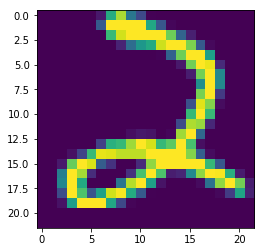

Test Example


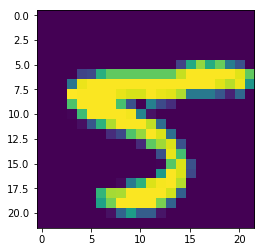

In [93]:
import matplotlib.pyplot as plt
import numpy as np
# PRINT THEIR LENGTHS AND VISUALISE AN EXAMPLE
x = train_data[np.random.randint(0, len(train_data))][0]    # get a random training example
print('Train Example')
plt.imshow(x[0].numpy())
plt.show()
x = test_data[np.random.randint(0, len(test_data))][0]    # get a random test example
print('Test Example')
plt.imshow(x[0].numpy())
plt.show()

In [94]:
# FURTHER SPLIT THE TRAINING INTO TRAINING AND VALIDATION
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])    # split into 50K training & 10K validation

In [95]:
batch_size = 128

# MAKE TRAINING DATALOADER
train_loader = torch.utils.data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE VALIDATION DATALOADER
val_loader = torch.utils.data.DataLoader(
    val_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE TEST DATALOADER
test_loader = torch.utils.data.DataLoader(
    test_data,
    shuffle=True,
    batch_size=batch_size
)

We define the architectures of our fully connected and convolutional networks as well as a function which returns the number of parameters in each model. Since the number of parameters in a model is a rough measure of its capacity, the networks should have an approximately equal number of parameters to make it a fair comparison.

In [102]:
import torch.nn.functional as F 

class FullyConnectedNet(torch.nn.Module):
    def __init__(self):
        super().__init__()    # initialise parent module
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(crop_size*crop_size, 225),
            torch.nn.ReLU(),
            torch.nn.Linear(225, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 10)
        )
    def forward(self, x):
        x = x.view(-1, crop_size*crop_size)
        x = self.fc_layers(x)
        x = F.softmax(x, dim=1)
        return x
    
class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = torch.nn.Sequential( # put your convolutional architecture here using torch.nn.Sequential 
            torch.nn.Conv2d(1, 16, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=5, stride=1),
            torch.nn.ReLU()
        )
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(64*(crop_size-12)*(crop_size-12), 10) # put your convolutional architecture here using torch.nn.Sequential 
            
        )
    def forward(self, x):
        x = self.conv_layers(x)# pass through conv layers
        x = x.view(x.shape[0], -1)# flatten output ready for fully connected layer
        x = self.fc_layers(x)# pass through fully connected layer
        x = F.softmax(x, dim=1)# softmax activation function on outputs
        return x

def get_n_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    n_params = sum([np.prod(p.size()) for p in model_parameters])
    return n_params

In [103]:
learning_rate = 0.0005 # set learning rate
epochs = 5 # set number of epochs
# SET UP TRAINING VISUALISATION
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter() # we will use this to show our models performance on a graph

In [104]:
cnn = ConvNet().to(device)#instantiate model
print('Number of parameters in cnn:', get_n_params(cnn))
criterion = torch.nn.CrossEntropyLoss() #use cross entropy loss function
optimiser = torch.optim.Adam(cnn.parameters(), lr=learning_rate) # use Adam optimizer, passing it the parameters of your model and the learning rate
train(cnn, epochs, verbose=False, tag='CNN Loss/Train')

Number of parameters in cnn: 128522
Training Complete. Final loss = 1.4745460748672485


In [105]:
fnn = FullyConnectedNet().to(device)
print('Number of parameters in fnn:', get_n_params(fnn))
optimiser = torch.optim.Adam(fnn.parameters(), lr=learning_rate) # use Adam optimizer, passing it the parameters of your model and the learning rate
train(fnn, epochs, verbose=False, tag='FNN Loss/Train')

Number of parameters in fnn: 137285
Training Complete. Final loss = 1.5748454332351685


In [106]:
print('CNN Train Accuracy:', calc_accuracy(cnn, train_loader))
print('CNN Validation Accuracy:', calc_accuracy(cnn, val_loader))
print('CNN Test Accuracy:', calc_accuracy(cnn, test_loader), '\n')

print('FNN Train Accuracy:', calc_accuracy(fnn, train_loader))
print('FNN Validation Accuracy:', calc_accuracy(fnn, val_loader))
print('FNN Test Accuracy:', calc_accuracy(fnn, test_loader))

CNN Train Accuracy: 97.932
CNN Validation Accuracy: 97.50999999999999
CNN Test Accuracy: 71.98 

FNN Train Accuracy: 87.044
FNN Validation Accuracy: 86.3
FNN Test Accuracy: 46.87


As we can see above, there is a significant disparity between the test accuracy of the two architectures, with the CNN have ~+20% test accuracy

# Scrambling test